In [48]:
# The code was removed by Watson Studio for sharing.

In [49]:
df.columns
type(df)
print(df.columns, 'are in order: \n offense type (str), offense cod (int), time (time), Latitude (float), Longitude, (float), SUSP_ETHINICITY (str), SUSPECT_AGE (str), SUSPECT_SEX (str), QUARTER (str), LOCATION (str)')
n_features = len(df.columns)
n_samples = df.count()
print('num samples, n=', n_samples, 'num features p=',n_features)

['OFNS_DESC', 'KY_CD', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_RACE', 'SUSP_AGE_GROUP', 'SUSP_SEX', 'PATROL_BORO', 'PREM_TYP_DESC'] are in order: 
 offense type (str), offense cod (int), time (time), Latitude (float), Longitude, (float), SUSP_ETHINICITY (str), SUSPECT_AGE (str), SUSPECT_SEX (str), QUARTER (str), LOCATION (str)
num samples, n= 343994 num features p= 11


In [50]:
import numpy as np
# select only last year complaint:
dateDT = np.array(df.rdd.map(lambda x: x.CMPLNT_FR_DT).collect())
mask2018 = np.array([dateDT[i].split('/')[2] == '2018' for i in np.arange(df.count())])
# select only complaint with know suspect age (we assume that our ROBOCOP is always able to discern a person age)
ageSTR = np.array(df.rdd.map(lambda x: x.SUSP_AGE_GROUP).collect())
maskAge = np.array([(ageSTR[i] == '<18') or (ageSTR[i] == '25-44') or (ageSTR[i] == '45-64')
or (ageSTR[i] == '65+')  for i in np.arange(df.count())])
# select only complaint with know suspect sex(we assume that our ROBOCOP is always able to discern a person sex)
sexSTR = np.array(df.rdd.map(lambda x: x.SUSP_SEX).collect())
maskSex = np.array([(sexSTR[i] == 'M') or (sexSTR[i] == 'F')  for i in np.arange(df.count())])

mask = mask2018*maskAge*maskSex

In [51]:
ofn = df.rdd.map(lambda x: x.OFNS_DESC).collect()
print (" There so many types of crimes:", len(set(ofn)))
set(ofn) # it might be our TARGET

 There so many types of crimes: 58


{'ABORTION',
 'ADMINISTRATIVE CODE',
 'AGRICULTURE & MRKTS LAW-UNCLASSIFIED',
 'ALCOHOLIC BEVERAGE CONTROL LAW',
 'ANTICIPATORY OFFENSES',
 'ARSON',
 'ASSAULT 3 & RELATED OFFENSES',
 "BURGLAR'S TOOLS",
 'BURGLARY',
 'CHILD ABANDONMENT/NON SUPPORT',
 'CRIMINAL MISCHIEF & RELATED OF',
 'CRIMINAL TRESPASS',
 'DANGEROUS DRUGS',
 'DANGEROUS WEAPONS',
 'DISORDERLY CONDUCT',
 'DISRUPTION OF A RELIGIOUS SERV',
 'ENDAN WELFARE INCOMP',
 'ESCAPE 3',
 'FELONY ASSAULT',
 'FORGERY',
 'FRAUDS',
 'FRAUDULENT ACCOSTING',
 'GAMBLING',
 'GRAND LARCENY',
 'GRAND LARCENY OF MOTOR VEHICLE',
 'HARRASSMENT 2',
 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
 'INTOXICATED & IMPAIRED DRIVING',
 'INTOXICATED/IMPAIRED DRIVING',
 'JOSTLING',
 'KIDNAPPING',
 'KIDNAPPING & RELATED OFFENSES',
 'LOITERING/GAMBLING (CARDS, DIC',
 'MISCELLANEOUS PENAL LAW',
 'NEW YORK CITY HEALTH CODE',
 'NYS LAWS-UNCLASSIFIED FELONY',
 'NYS LAWS-UNCLASSIFIED VIOLATION',
 'OFF. AGNST PUB ORD SENSBLTY &',
 'OFFENSES AGAINST PUBLIC ADMINI',
 'OFFENSE

In [52]:
                                                ### LOADING ###
''' load ofn type '''
ofnStr = np.array(ofn)[mask]#np.array(df.rdd.map(lambda x: x.CMPLNT_FR_DT)).collenct()
# load ofn types coded with a 3 digit nums
ofnCod = np.array(df.rdd.map(lambda x: x.KY_CD).collect())[mask]
# this instead will have the first Natural nums
ofnInt = np.zeros(ofnCod.shape)
# create dict of cod2ofn and convert code
ofn_dict = {}  
ofnCod, ofnStr
for i, cod in enumerate(set(ofnCod)):
    # just a check
    #ofnStr[np.where(ofnCod==cod)[0]]# this elements should be all equal 
    # within an iteration but different across iterations
    ofnInt[np.where(ofnCod==cod)] = i
    ofn_dict['{}'.format(i)] = (cod,ofnStr[np.where(ofnCod==cod)[0]][0])

''' load space and time'''
latitudeR = np.array(df.rdd.map(lambda x: x.X_COORD_CD).collect())[mask]
longitudeR = np.array(df.rdd.map(lambda x: x.Y_COORD_CD).collect())[mask]
timeDT = np.array(df.rdd.map(lambda x: x.CMPLNT_FR_TM).collect())[mask]
# convert time in second from midnight
timeSec = np.zeros(timeDT.shape)
for i, t in enumerate(timeDT):
    h, mn, sec = t.split(':')
    h = int(h)
    mn = int(mn)
    sec = int(sec)
    timeSec[i] = 3600*h+60*mn+sec
    
''' load ethnicity'''
etnStr = np.array(df.rdd.map(lambda x: x.SUSP_RACE).collect())[mask]
etnInt = np.zeros(etnStr.shape)
etn_dict = {}
for i,etn in enumerate(set(etnStr)):
    #print(etn)
    etn_dict[i] = etnStr[np.where(etnStr==etn)][0]
    etnInt[np.where(etnStr==etn)] = i

'''load season'''
seasons = {'spring':['3','4','5'],'summer':['6','7','8'],'autumn':['9','10','11'],'winter': ['12','1','2']}
dateDT = np.array(df.rdd.map(lambda x: x.CMPLNT_FR_DT).collect())[mask]
seaInt = np.zeros(dateDT.shape)
sea_dict = {}
for i, season in enumerate(seasons.keys()):
    #print(season)
    sea_dict[i] = season
    seaInd = np.array([dateDT[j].split('/')[0] in seasons[season] for j in np.arange(len(dateDT))])
    seaInt[seaInd] = i

''' load day of the week'''
# to fill with ord num of day from 1/1/2018
dayOrd = np.zeros(dateDT.shape)
day4month = [0,31,28,31,30,31,30,31,31,30,31,30,31]
cumDay4Month = np.cumsum(day4month)
for i, d in enumerate(dateDT):
    mth, day, _ = d.split('/')
    dayOrd[i] = cumDay4Month[int(mth)-1]+int(day)
    
day_dict = {'1': 'Mon', '2':'Tue', '3':'Wed', '4':'Thu', '5':'Fri', '6':'Sat', '7':'Sun'}    
dayInt = np.zeros(dateDT.shape) 
for j in np.arange(len(dateDT)):
    dayInt[j] = (dayOrd[j]%7)  # luckly the 2018 started on Monday

''' load sups age'''
ageStr = np.array(df.rdd.map(lambda x: x.SUSP_AGE_GROUP).collect())[mask]
ageInt = np.zeros(ageStr.shape)
age_dict = {}
for i,age in enumerate(set(ageStr)):
    #print(age)
    age_dict[i] = ageStr[np.where(ageStr==age)][0]
    ageInt[np.where(ageStr==age)] = i

''' load sups sex'''
sexStr = np.array(df.rdd.map(lambda x: x.SUSP_SEX).collect())[mask]
sexInt = np.zeros(sexStr.shape)
sex_dict = {}
for i,sex in enumerate(set(sexStr)):
    #print(sex)
    sex_dict[i] = sexStr[np.where(sexStr==sex)][0]
    sexInt[np.where(sexStr==sex)] = i
    
''' load district'''
distStr = np.array(df.rdd.map(lambda x: x.PATROL_BORO).collect())[mask]
distInt = np.zeros(distStr.shape)
dist_dict = {}
for i, dist in enumerate(set(distStr)):
    ##print(dist)
    dist_dict[i] = distStr[np.where(distStr==dist)][0]
    distInt[np.where(distStr==dist)] = i
 
''' load location'''
locStr = np.array(df.rdd.map(lambda x: x.PREM_TYP_DESC).collect())[mask]
locInt = np.zeros(locStr.shape)
loc_dict = {}
for i, loc in enumerate(set(locStr)):
    #print(loc)
    loc_dict[i] = locStr[np.where(locStr==loc)][0]
    locInt[np.where(locStr==loc)] = i

In [53]:
# this is reduced to 2018 samples
n_samples = len(ofnStr)
n_samples

170582

In [54]:
# convert to flaot TODO: improve
latitudeR = np.array([float(l) for l in latitudeR])
longitudeR = np.array([float(l) for l in longitudeR])
# Normalize continuous feature
latNorm = (latitudeR - np.mean(latitudeR))/np.std(latitudeR)
lonNorm = (longitudeR -  np.mean(longitudeR))/np.std(longitudeR)
timeNorm = (timeSec - np.mean(timeSec))/np.std(timeSec)
# 1 hot encode discrete feature
seaCat = to_categorical(seaInt, 4)
dayCat = to_categorical(dayInt, 7)
etnCat = to_categorical(etnInt, 7)
ageCat = to_categorical(ageInt, 4)
sexCat = to_categorical(sexInt, 2)
distCat = to_categorical(distInt, 8)
locCat = to_categorical(locInt, 72)

${\large\bf{THEORY}}$:

Note that  $[\textit{np.where(ofnStr==Str)}]$ forms a subset $\Omega_{Str}$ of $\Omega$, s.t. $X_{ofn}(\omega)=Str$ for every $\omega$ in $\Omega_{Str}$. This is the counter-image of the R.V. $X_{ofn}$. For all values of $Str$, the corresponding subsets  form a partition of $\Omega$ that generates a sub-algbebra.

The same holds for all the other features. Thus, our oiriginal data $\Omega$ is partioned as the space product $\Omega=\Omega_{Str} *\Omega_{time} * \Omega_{day} * \Omega_{latitude}$.... of the partions generated from each varables.

The ${\bf{GOAL}}$ of this analysis is to study $X_{ofn}|(X_{time},X_{day},X_{latitude}...)$, after having learnt from that partition; i.e. predict the type of crime one will eventually commit, given the fact that our ROBOCOP have observed all other variables.

NOTA BENE:
We are biased toward the fact that our data comes from complaints, so we have observed only felony. Our robot should be also trainend on data $(X_{time},X_{day},X_{latitude}...)$ coming from innocent people (for which $X_{Str}=None$) and weights its decision consequently. 
Otherwise we might fall in what E.T.JAYNES called the "THE MIND PROJECTION FALLACY"... And many innocents will be arrested unjustly.

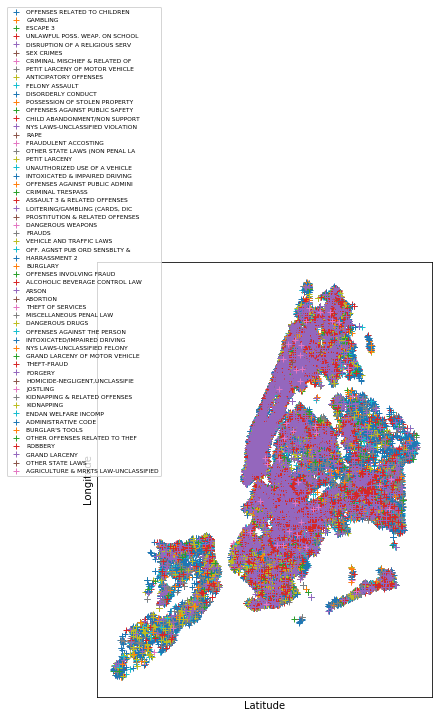

In [55]:
### PLOTTING lat-long SATTER ###
fig1 = plt.figure(figsize=(6,8))
ax1 = fig1.add_subplot(111)
for ofn in set(ofnStr):
    ax1.plot(latitudeR[np.where(ofnStr == ofn)[0]], longitudeR[np.where(ofnStr == ofn)[0]], '+', label = ofn)
ax1.set_ylabel('Longitude')
ax1.set_xlabel('Latitude')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend(loc='best', prop={'size': 6}, bbox_to_anchor=(0.2, 0.5),ncol=1, fancybox=True)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

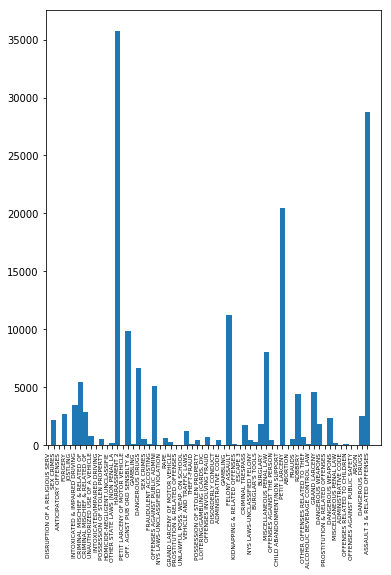

In [56]:
### PLOTTING ofn HISTO ###
fig2 = plt.figure(figsize=(6,8))
ax2 = fig2.add_subplot(111)

num_ofn = len(ofn_dict)
#print(num_ofn,ofnInt,ofnStr)
#print(ofn_dict)
bins = ax2.hist(ofnInt, range=[-0.5, num_ofn+1.5], bins=num_ofn+2)
ax2.set_xlim([-0.5, num_ofn+1.5])
ax2.set_xticks(np.arange(num_ofn))
ax2.set_xticklabels(ofn_dict['{}'.format(i)][1] for i in np.arange(num_ofn))
plt.xticks(fontsize = 6, rotation=90)

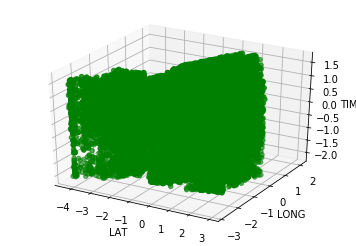

In [57]:
### PLOTTING lat-long-time SCATTER ###
fig3 = plt.figure(figsize=(6,8))
ax = fig3.add_subplot(111, projection='3d',aspect=True)
ax.scatter(latNorm, lonNorm, timeNorm, c='g', marker='o')
ax.set_xlabel('LAT')
ax.set_ylabel('LONG')
ax.set_zlabel('TIME')

plt.show()

$\Large{OBSERVATION}$:

1 - no clear cluster is visible in fig1

2 - the distribution of crime type is far from being uniform

3 - from the scatter plot in fig3 it is hard to see a (linear) correlation between time and space coordinates

Since there are too many ofn (Str) values to predict and many of those are similar strings, we merge the onf values that contain certian same words. 

THEORY: this mean to generate a new less ${\textit{fine}}$ partition with subset: $\Omega_{word}=\cup\Omega_{Str}$ for $Str$ s.t. $word \in Str$. 

In [58]:
### MERGE CLASSES ###
y1Str = ['ADMINISTRATIVE']
y2Str = ['INTOXICATED', 'ALCOHOLIC']
y3Str = ['ROBBERY', 'THEFT', 'STOLEN', 'LARCENY']
y4Str = ['PROSTITUTION', 'SEX', 'HARRASAMENT']
y5Str = ['HOMICIDE', 'MURDER', 'ASSAULT', 'RAPE','WEAPOSN'] 
         
yDict = {0:'rest',1:'admin.',2:'drug',3:'theft',4:'sex',5:'violence'}
y1Ind = []
for ofn1 in y1Str:
    for o in set(ofnStr):
        if ofn1 in o: #check if keyword is contained in offense string
            y1Ind = np.hstack((y1Ind, (np.where(ofnStr == o)[0])))
            
y2Ind = []
for ofn2 in y2Str:
    for o in set(ofnStr):
        if ofn2 in o:
            y2Ind = np.hstack((y2Ind, (np.where(ofnStr == o)[0])))
            
y3Ind = []            
for ofn3 in y3Str:
    for o in set(ofnStr):
        if ofn3 in o:
            y3Ind = np.hstack((y3Ind, (np.where(ofnStr == o)[0])))
         
y4Ind = []            
for ofn4 in y4Str:
    for o in set(ofnStr):
        if ofn4 in o:
            y4Ind = np.hstack((y4Ind, (np.where(ofnStr == o)[0])))
            
y5Ind = []            
for ofn5 in y5Str:
    for o in set(ofnStr):
        if ofn5 in o:
            y5Ind = np.hstack((y5Ind, (np.where(ofnStr == o)[0])))

# we need set to operate with intersaction and differences
y1Ind = set(y1Ind)
y2Ind = set(y2Ind)
y3Ind = set(y3Ind)
y4Ind = set(y4Ind)
y5Ind = set(y5Ind)
# if a offense is belonging to 2 classes, we put it in the most dangerous
y1Ind = y1Ind - y1Ind.intersection(y2Ind) - y1Ind.intersection(y3Ind) - y1Ind.intersection(y4Ind) - y1Ind.intersection(y5Ind)
y2Ind = y2Ind - y2Ind.intersection(y3Ind) - y2Ind.intersection(y4Ind) - y2Ind.intersection(y5Ind)
y3Ind = y3Ind - y3Ind.intersection(y4Ind) - y3Ind.intersection(y5Ind)
y4Ind = y4Ind - y4Ind.intersection(y5Ind)
yRestInd = set(np.arange(n_samples))
yRestInd = yRestInd -y1Ind-y2Ind-y3Ind-y4Ind-y5Ind
yRestInd = list(yRestInd)
y1Ind = np.array(list(y1Ind), dtype=int)
y2Ind = np.array(list(y2Ind), dtype=int)
y3Ind = np.array(list(y3Ind), dtype=int)
y4Ind = np.array(list(y4Ind), dtype=int)
y5Ind = np.array(list(y5Ind), dtype=int)
yRestInd = list(yRestInd)
y = np.zeros(n_samples)
y[yRestInd]=0
y[y1Ind]=1
y[y2Ind]=2
y[y3Ind]=3
y[y4Ind]=4
y[y5Ind]=5
# check dim
print(len(yRestInd)+len(y1Ind)+len(y2Ind)+len(y3Ind)+len(y4Ind)+len(y5Ind), n_samples)

170582 170582


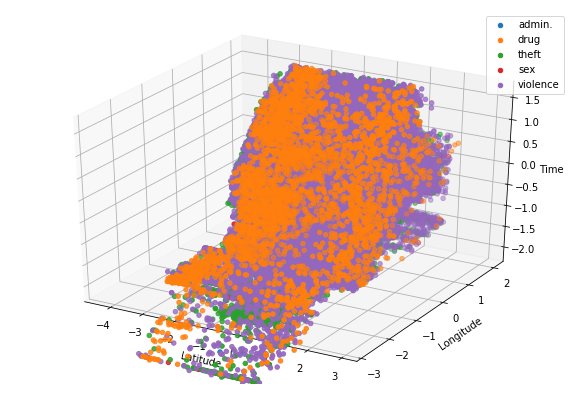

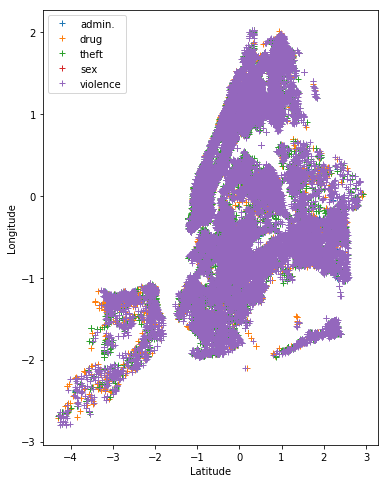

In [59]:
#### Scatter with class ###
fig3 = plt.figure(figsize=(10,12))
ax3 = fig3.add_subplot(111, projection='3d',aspect=True)
colors = ['g','b','r', 'y', 'o']
for j, clas in enumerate([y1Ind,y2Ind,y3Ind,y4Ind,y5Ind]):
    ax3.scatter(latNorm[clas], lonNorm[clas], timeNorm[clas], 'x', label = yDict[j+1])
ax3.set_ylabel('Longitude')
ax3.set_xlabel('Latitude')
ax3.set_zlabel('Time')
ax3.legend()
plt.show()

fig4 = plt.figure(figsize=(6,8))
ax4 = fig4.add_subplot(111)#, projection='3d',aspect=True)
for j, clas in enumerate([y1Ind,y2Ind,y3Ind,y4Ind,y5Ind]):
    ax4.plot(latNorm[clas], lonNorm[clas], '+', label = yDict[j+1])
ax4.set_ylabel('Longitude')
ax4.set_xlabel('Latitude')
ax4.legend()
plt.show()

3 - This scatter togheter with fig1 may suggest to exclude the presence of spherical clusters, and thus to not use Kmeans.

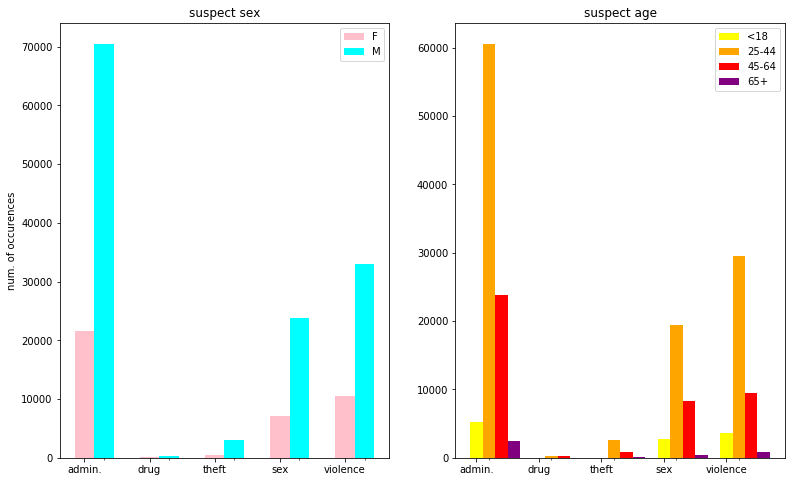

In [60]:
### Histo by classes
fig5 = plt.figure(figsize=(13,8))
ax5 = fig5.add_subplot(121)
barWidth = 0.3
bars1 = np.histogram(y[np.where(sexStr=='M')[0]],bins=5)
bars2 = np.histogram(y[np.where(sexStr=='F')[0]],bins=5)
r1 = np.arange(len(bars1[0]))
r2 = [j + barWidth for j in r1]
ax5.bar(r1, bars2[0], width = barWidth, color = 'pink', label='F')
ax5.bar(r2, bars1[0], width = barWidth, color = 'cyan', label='M')
ax5.set_xticks([r + barWidth for r in range(len(bars1[0]))], yDict.values())
ax5.set_xticklabels(yDict.values())
ax5.set_ylabel('num. of occurences')
ax5.set_title('suspect sex')
ax5.legend()


ax6 = fig5.add_subplot(122)
barWidth = 0.4
bars1 = np.histogram(y[np.where(ageStr=='<18')[0]],bins=5)
bars2 = np.histogram(y[np.where(ageStr=='25-44')[0]],bins=5)
bars3 = np.histogram(y[np.where(ageStr=='45-64')[0]],bins=5)
bars4 = np.histogram(y[np.where(ageStr=='65+')[0]],bins=5)
r1 = np.arange(0,len(bars1[0])*2,2)
r2 = [j + barWidth for j in r1]
r3 = [j + barWidth for j in r2]
r4 = [j + barWidth for j in r3] 
ax6.bar(r1, bars1[0], width = barWidth, color = 'yellow', label='<18')
ax6.bar(r2, bars2[0], width = barWidth, color = 'orange', label='25-44')
ax6.bar(r3, bars3[0], width = barWidth, color = 'red', label='45-64')
ax6.bar(r4, bars4[0], width = barWidth, color = 'purple', label='65+')
ax6.set_title('suspect age')
ax6.set_xticks([r + barWidth for r in range(0,len(bars1[0])*2,2)], yDict.values())
ax6.set_xticklabels(yDict.values())
ax6.legend()

plt.show()

In [61]:
### Data Preparation ###
# Input values
x = np.vstack(((latNorm**2+lonNorm**2), latNorm, lonNorm, timeNorm, timeNorm**3, 
               seaCat.T, etnCat.T, dayCat.T, ageCat.T, sexCat.T, distCat.T, locCat.T)).T
# Output 
y = to_categorical(y,6)
# Check dim
print(x.shape,y.shape)
num_classes = y.shape[1]
inputDim = x.shape[1]

# Split Data
percTrain = 0.8
percVal = 0.1
#percTest = 0.1
# training set
x_train = x[:int(n_samples*percTrain)]
y_train = y[:int(n_samples*percTrain)]
# validation test
x_val = x[int(n_samples*percTrain):int(n_samples*(percTrain+percVal))]
y_val = y[int(n_samples*percTrain):int(n_samples*(percTrain+percVal))]
# test set
x_test = x[int(n_samples*(percTrain+percVal)):]
y_test = y[int(n_samples*(percTrain+percVal)):]
# N.B. Data are not shuffled since we want our ROBOCOP to learn from the past and predict the future. So are the data ordered

(170582, 109) (170582, 6)


In [64]:
### Model definition
model = Sequential()
n_1 = 109 # units in layer 1
n_2 = 327 # units in layer 2
n_3 = 327 # units in layer 3
n_4 = 60 # units in layer 4
batch_size = 50
epochs = 100

model.add(Dense(n_1, input_shape=(inputDim,)))
model.add(Dense(n_2, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(n_3, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(n_4, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(num_classes, activation='softmax'))

In [65]:
### Model Training
now = datetime.datetime.now()
print(now)
model.compile(loss='categorical_crossentropy',
        optimizer='sgd',
        metrics = [categorical_accuracy])

model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs = epochs,
        shuffle=True,
        validation_data=(x_val, y_val))

now1 = datetime.datetime.now() 
print('It took', now1-now,3)

2019-05-20 03:59:34.751659
Train on 136465 samples, validate on 17058 samples
Epoch 1/100
136465/136465 [==============================] - 17s 127us/step - loss: 1.0719 - categorical_accuracy: 0.5757 - val_loss: 0.9341 - val_categorical_accuracy: 0.6348
Epoch 2/100
136465/136465 [==============================] - 17s 122us/step - loss: 0.9718 - categorical_accuracy: 0.6149 - val_loss: 0.9094 - val_categorical_accuracy: 0.6407
Epoch 3/100
136465/136465 [==============================] - 17s 122us/step - loss: 0.9554 - categorical_accuracy: 0.6181 - val_loss: 0.8955 - val_categorical_accuracy: 0.6418
Epoch 4/100
136465/136465 [==============================] - 17s 125us/step - loss: 0.9462 - categorical_accuracy: 0.6200 - val_loss: 0.8934 - val_categorical_accuracy: 0.6442
Epoch 5/100
136465/136465 [==============================] - 16s 120us/step - loss: 0.9404 - categorical_accuracy: 0.6216 - val_loss: 0.8928 - val_categorical_accuracy: 0.6450
Epoch 6/100
136465/136465 [===============

In [66]:
### Model evaluation
print(len(yRestInd)/float(n_samples))      
score = model.evaluate(x_test, y_test)
print('loss=',score[0], 'accuracy=',score[1])

0.5399280111617873
17059/17059 [==============================] - 1s 46us/step
loss= 0.878358941375 accuracy= 0.642769212732
